In [1]:
import csv
import datetime
import isodate
import numpy as np
import time
import re
import operator
import sys
import urltools
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import matplotlib
from matplotlib_venn import venn3
from PIL import Image, ImageDraw, ImageFont

In [2]:
def get_pct(num, denom):
    return str(round((num*1.0/denom)*100, 2)) + "%"

clean out diary study participants

In [3]:
participant_ids = []
with open("study_participants.tsv", 'rt') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    for row in reader:
        participant_ids.append(row[0])

Put the information into an list

In [4]:
items = []

In [5]:
count = 0
headers = None
removed_item_count = 0
#with open("test.tsv", 'rt') as csvfile:
with open("AdIntuitionData.tsv", 'rt') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    for row in reader:
        count += 1
        if count == 1:
            headers = row
            continue
        if row[2] in participant_ids:
            removed_item_count += 1
            continue
        items.append(row)

In [6]:
print removed_item_count

1137


In [7]:
print headers

['xid', 'action', 'UserId', 'time', 'highlighted', 'video']


# Check and Clean Coupon Codes

In [8]:
counts = {}
tagged_coupon_codes = {}
total = 0
with open("couponcodes/coupons.tsv", 'rt') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    for row in reader:
        if row[0] in ["0","1","2", "3"]:
            num = row[0]
            if num == "3":
                num = '0'
            if num not in counts:
                counts[num] = 0
            counts[num] += 1
            total += 1
            tagged_coupon_codes[row[1]] = num

print counts
print (counts["1"]*1.0/(counts["1"]+counts["0"]))*100

{'1': 2026, '0': 470, '2': 43}
81.1698717949


# Check and Clean UTM Success

In [9]:
count = 0
total = 0
seen_count = 0
seen_total = 0
utm_items_saver = []
utm_init_urls = []
with open("checkutms/utms_with_redirects.tsv", 'rt') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    for row in reader:
        seen = int(row[0])
        for url in row[1:]:
            if len(url) < 2:
                continue
            utm_items_saver.append(url)
            if re.search("(=aff)|(=infl)|(aff_id=)|(aff=)|(sponsor)|(=paid)|(=ref)|(ref_id=)|(promotion)|(ref=)|(referral)|(affiliate)|(influencer)", url.lower()):
                utm_init_urls.append(row[1])
                count += 1
                seen_count += seen
                break
        total += 1
        seen_total += seen

In [10]:
print count
print total
print (count*1.0/total)*100

927
2788
33.2496413199


In [11]:
print seen_count
print seen_total
print (seen_count*1.0/seen_total)*100

2191
5825
37.6137339056


# How often does the average user see affiliate marketing

In [12]:
total_videos_watched = 0
aff_videos_watched = 0
time_diff = 15
vid_dups = 0
max_dt = 0
videos_by_user = {} #user: time (rounded to within x seconds either way): video
tot_vids_by_user = {}
day_indexed_user_videos = {}

utm_counter = 0
utm_counter2 = 0
coupon_code_counter = 0 
coupon_code_counter2 = 0
coupon_code_counter3 = 0

for item in items:
    uid = item[2]
    ti = int(item[3])
    if ti > max_dt:
        max_dt = ti
    t = datetime.datetime.fromtimestamp(ti).strftime('%Y-%m-%d')
    vid_id = item[5]
    action = item[1]
    highlighted = item[4]
    if uid not in videos_by_user:
        videos_by_user[uid] = {}
    if uid not in day_indexed_user_videos:
        day_indexed_user_videos[uid] = {}
    if action == 'vid_watch':
        total_videos_watched += 1
        if uid not in tot_vids_by_user:
            tot_vids_by_user[uid] = 0
        tot_vids_by_user[uid] += 1
        
        if t not in day_indexed_user_videos[uid]:
            day_indexed_user_videos[uid][t] = {}
        if 'tot' not in day_indexed_user_videos[uid][t]:
            day_indexed_user_videos[uid][t]['tot'] = 0
        day_indexed_user_videos[uid][t]['tot'] += 1
        
    if action not in ['aff', 'utm', 'coupon_code']:
        continue
    if action == 'utm':
        if highlighted not in utm_init_urls:
            utm_counter2 += 1
            continue
        else:
            utm_counter += 1
    if action == 'coupon_code':
        coupon_code_counter += 1
        if highlighted not in tagged_coupon_codes:
            coupon_code_counter2 += 1
            continue
        if tagged_coupon_codes[highlighted] != "1":
            coupon_code_counter3 += 1
            continue
    found = False
    for i in range(ti-time_diff, ti+time_diff):
        if i in videos_by_user[uid]:
            if vid_id in videos_by_user[uid][i]:
                vid_dups += 1 #number of times that highlights happen on a vid
            else:
                videos_by_user[uid][i].append(vid_id)
                aff_videos_watched += 1
                
                if t not in day_indexed_user_videos[uid]:
                    day_indexed_user_videos[uid][t] = {}
                if 'aff' not in day_indexed_user_videos[uid][t]:
                    day_indexed_user_videos[uid][t]['aff'] = 0
                day_indexed_user_videos[uid][t]['aff'] += 1
                
            found = True
            break  
    if not found:
        videos_by_user[uid][ti] = [vid_id]
        aff_videos_watched += 1
        
        if t not in day_indexed_user_videos[uid]:
            day_indexed_user_videos[uid][t] = {}
        if 'aff' not in day_indexed_user_videos[uid][t]:
            day_indexed_user_videos[uid][t]['aff'] = 0
        day_indexed_user_videos[uid][t]['aff'] += 1          

In [13]:
print coupon_code_counter
print coupon_code_counter2
print coupon_code_counter3
print
print utm_counter
print utm_counter2

4423
8
761

2178
3689


In [14]:
d = datetime.datetime.fromtimestamp(max_dt).strftime('%m/%d/%Y %H:%M:%S')
print "Most recent data entry: " + d

Most recent data entry: 08/26/2019 18:30:38


In [15]:
aff_num = str(aff_videos_watched) + " videos with affiliate marketing"
print aff_num
tot = str(total_videos_watched) + " videos total watched"
print tot
affiliate_percent = get_pct(aff_videos_watched, total_videos_watched)
print affiliate_percent

6506 videos with affiliate marketing
60835 videos total watched
10.69%


# Is the average accurate?

In [16]:
tot_seen = []
aff_seen = []
percentage_by_user = {}

In [17]:
for user in tot_vids_by_user.keys():
    affs = 0
    if user in videos_by_user:
        for moment in videos_by_user[user]:
            for vid in videos_by_user[user][moment]:
                affs += 1
#     if affs > 300:
#         print user
    tot_seen.append(tot_vids_by_user[user])
    aff_seen.append(affs)
    if tot_vids_by_user[user] == 0:
        percentage_by_user[user] = 0
    else:
        if affs > tot_vids_by_user[user]:
            #print user
            # there are a couple edge cases where this could happen. Deleted data, unsuccessful http calls, 
            pass
        percentage_by_user[user] = (affs*1.0)/tot_vids_by_user[user]

In [18]:
#filter out one user with many more data points than everyone else
for i in range(len(tot_seen)):
    if tot_seen[i] > 10000:
        tot_seen.pop(i)
        aff_seen.pop(i)
        break

In [19]:
#Create a line of best fit
z = np.polyfit(tot_seen, aff_seen, 1)
p = np.poly1d(z) #this gives us a function for the averages
average_vals_x = []
average_vals_y = []
i = 0
while i < max(tot_seen):
    average_vals_x.append(i)
    average_vals_y.append(p(i))
    if i < 50:
        i += 1
    else:
        i += 5

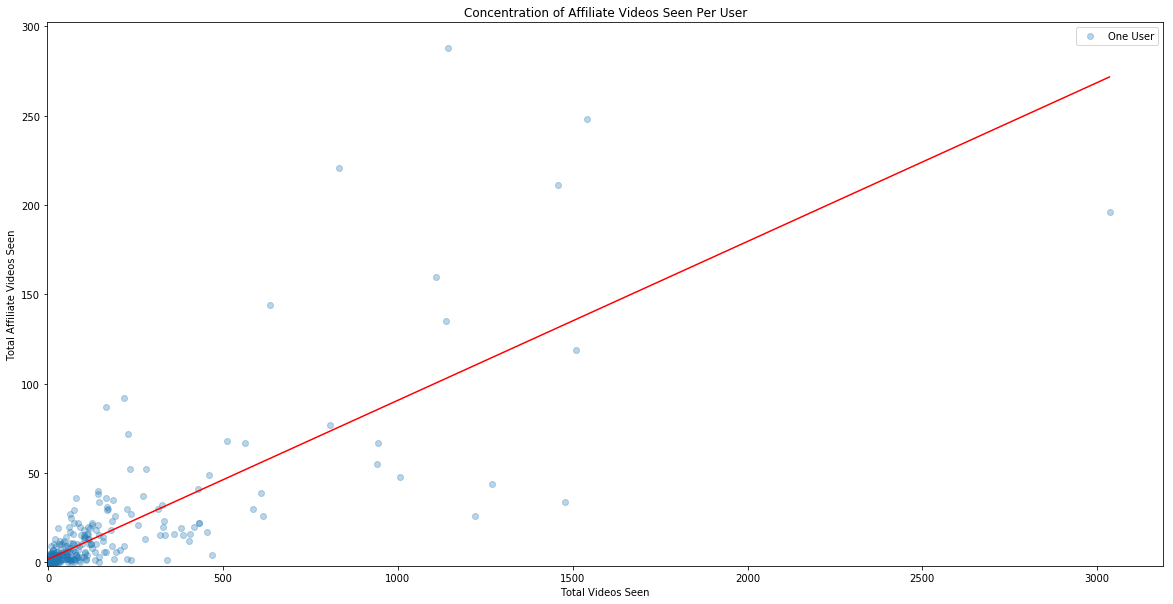

In [20]:
plt.figure(figsize=(20,10))
plt.scatter(tot_seen, aff_seen, alpha=0.3)
plt.plot(average_vals_x, average_vals_y, "r-", label='Line of Best Fit')
plt.title('Concentration of Affiliate Videos Seen Per User')
plt.xlabel('Total Videos Seen')
plt.ylabel('Total Affiliate Videos Seen')
plt.xlim(-3)
plt.ylim(-2)
plt.legend([
    matplotlib.lines.Line2D([], [], marker='.', alpha=0.3, linestyle='None',markersize=12, label='One User')], ['One User'])
plt.show()

In [21]:
med_tot_seen = statistics.median(tot_seen)
med_aff_seen = statistics.median(aff_seen)
print "median affiliate/median total videos seen"
print str(med_aff_seen) + "/" + str(med_tot_seen)
print get_pct(med_aff_seen, med_tot_seen)

median affiliate/median total videos seen
2.0/24.0
8.33%


In [22]:
med_tot_seen = statistics.mean(tot_seen)
med_aff_seen = statistics.mean(aff_seen)
print "mean affiliate/mean total videos seen"
print str(round(med_aff_seen,2)) + "/" + str(round(med_tot_seen,2))
print get_pct(med_aff_seen, med_tot_seen) # this should match the number found above

mean affiliate/mean total videos seen
12.65/122.87
10.29%


# What happens when we begin only looking at top users?

In [23]:
# number of days that a user has been active
users = {}
for item in items:
    uid = item[2]
    ti = int(item[3])
    t = datetime.datetime.fromtimestamp(ti).strftime('%Y-%m-%d')
    if uid not in users:
        users[uid] = {}
    if t not in users[uid]:
        users[uid][t] = 0
    users[uid][t] += 1

In [24]:
number_of_days_active = {}
total_users = 0
for user in users:
    total_users += 1
    days_active = len(users[user].keys())
    if days_active not in number_of_days_active:
        number_of_days_active[days_active] = 0
    number_of_days_active[days_active] += 1

In [25]:
print total_users

472


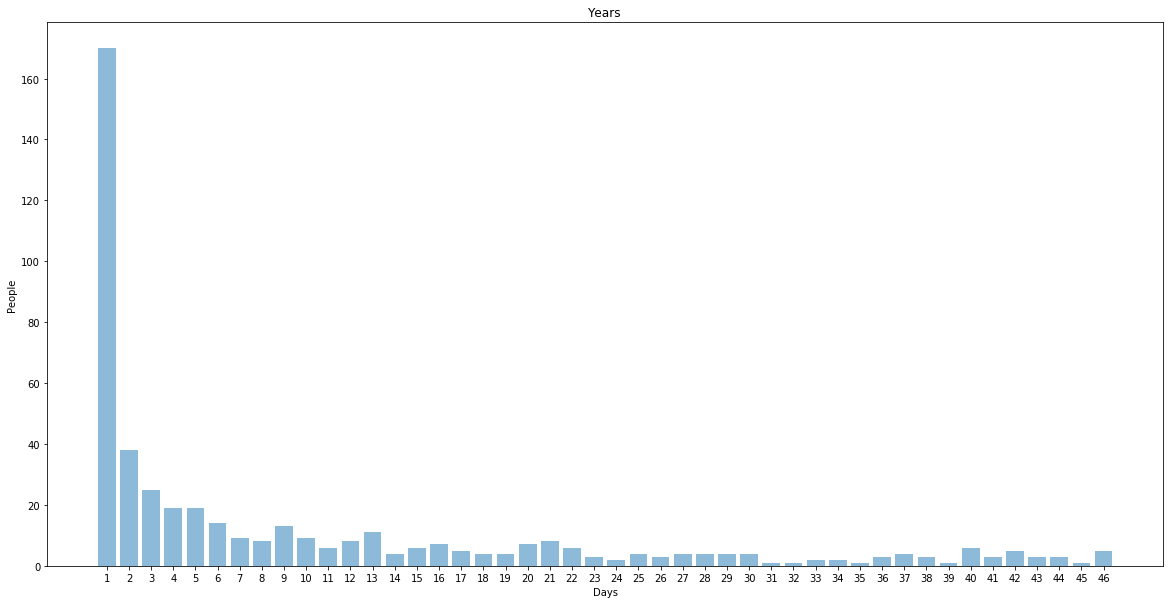

In [26]:
plt.figure(figsize=(20,10))
lists = sorted(number_of_days_active.items()) # sorted by key, return a list of tuples
x, y = zip(*lists)
plt.bar(x, y, align='center', alpha=0.5)
plt.xticks(x, sorted(number_of_days_active.keys()))
plt.title("Years")
plt.ylabel('People')
plt.xlabel('Days')
plt.show()
    

In [27]:
#we want to check multiple limits, but do not want our pool of users to get too small
total_users_i = total_users
max_days_active = 0
PERCENTAGE_OF_TOP_USERS_TO_STOP_AT = total_users*1.0/10
for days_active in sorted(number_of_days_active.keys()):
    total_users_i -= number_of_days_active[days_active]
    max_days_active = days_active
    if total_users_i < PERCENTAGE_OF_TOP_USERS_TO_STOP_AT:
        break

In [28]:
def get_metrics_for_days_active(min_days_active):
    tot_seen = []
    aff_seen = []
    for user in tot_vids_by_user.keys():
        affs = 0
        if user in videos_by_user:
            if len(users[user].keys()) <= min_days_active:
                continue
            for moment in videos_by_user[user]:
                for vid in videos_by_user[user][moment]:
                    affs += 1
        tot_seen.append(tot_vids_by_user[user])
        aff_seen.append(affs)
    med_tot_seen = statistics.median(tot_seen)
    med_aff_seen = statistics.median(aff_seen)
    mean_tot_seen = statistics.mean(tot_seen)
    mean_aff_seen = statistics.mean(aff_seen)
    return med_tot_seen, med_aff_seen, mean_tot_seen, mean_aff_seen

In [29]:
limit_of_days = []
median_pct = []
mean_pct = []
for i in range(0,max_days_active):
    tot, aff, totm, affm = get_metrics_for_days_active(i)
    limit_of_days.append(i)
    mean_pct.append((affm*1.0)/totm)
    median_pct.append((aff*1.0)/tot)

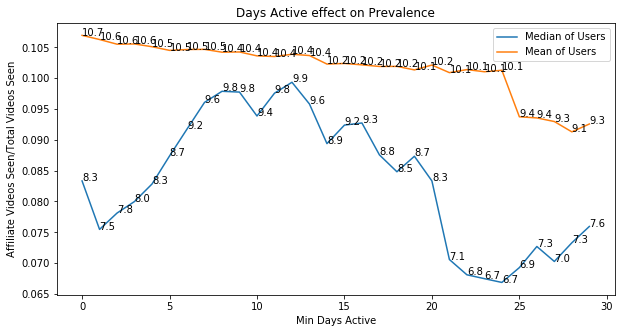

In [30]:
plt.figure(figsize=(10,5))
plt.plot(limit_of_days, median_pct, label="Median of Users")
plt.plot(limit_of_days, mean_pct, label="Mean of Users")
plt.legend()
plt.title("Days Active effect on Prevalence")
plt.xlabel('Min Days Active')
plt.ylabel('Affiliate Videos Seen/Total Videos Seen')
for i in range(len(limit_of_days)):
    if mean_pct[i] > 0:
        plt.annotate(str(round(mean_pct[i],3)*100), (limit_of_days[i], mean_pct[i]))
for i in range(len(limit_of_days)):
    if median_pct[i] > 0:
        plt.annotate(str(round(median_pct[i],3)*100), (limit_of_days[i], median_pct[i]))
plt.show()

In [31]:
days_active_list = []
percentage_list = []
for user in users:
    days_active = len(users[user].keys())
    percent = 0
    if user in percentage_by_user:
        percent = percentage_by_user[user]
    days_active_list.append(days_active)
    percentage_list.append(percent)

In [32]:
percentages_by_days_active = {}
for days_active in sorted(number_of_days_active.keys()):
    percentages_by_days_active[days_active] = []
    for user in users:
        days_count = len(users[user].keys())
        if days_count == days_active:
            percent = 0
            if user in percentage_by_user:
                percent = percentage_by_user[user]
            percentages_by_days_active[days_active].append(percent)

In [33]:
avg_per_days_active = {}
median_per_days_active = {}
for day in percentages_by_days_active.keys():
    avg_per_days_active[day] = statistics.mean(percentages_by_days_active[day])
    median_per_days_active[day] = statistics.median(percentages_by_days_active[day])

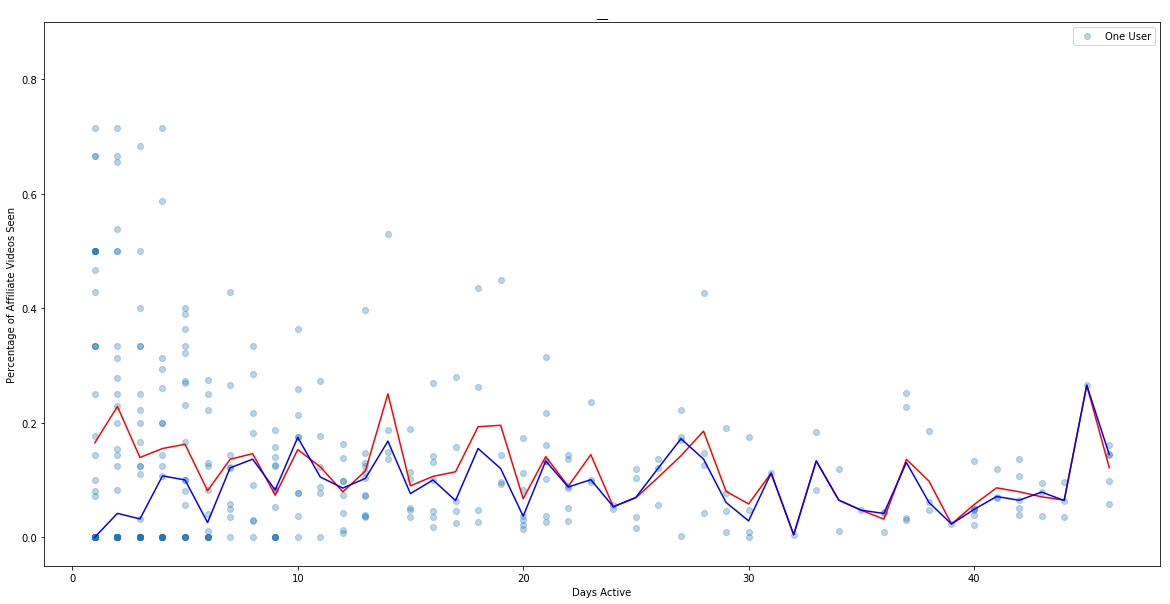

In [34]:
plt.figure(figsize=(20,10))
plt.scatter(days_active_list, percentage_list, alpha=0.3)
lists = sorted(avg_per_days_active.items()) # sorted by key, return a list of tuples
x, y = zip(*lists)
plt.plot(x, y, "r-", label='Line of Best Fit Mean')
lists = sorted(median_per_days_active.items()) # sorted by key, return a list of tuples
x, y = zip(*lists)
plt.plot(x, y, "b-", label='Line of Best Fit Mean')
plt.title('__')
plt.ylabel('Percentage of Affiliate Videos Seen')
plt.xlabel('Days Active')
plt.ylim(-0.05,0.9)
plt.legend([
    matplotlib.lines.Line2D([], [], marker='.', alpha=0.3, linestyle='None',markersize=12, label='One User')], ['One User'])
plt.show()

In [35]:
day_indexed_integer_user_videos = {}
for user in day_indexed_user_videos:
    day_indexed_integer_user_videos[user] = {}
    day_count = 0
    for day in sorted(day_indexed_user_videos[user]):
        day_count += 1
        aff_temp = 0
        if 'aff' in day_indexed_user_videos[user][day]:
            aff_temp = day_indexed_user_videos[user][day]['aff']
        tot_temp = 1
        if 'tot' in day_indexed_user_videos[user][day]:
            tot_temp = day_indexed_user_videos[user][day]['tot']
        percentage = (aff_temp*1.0)/tot_temp
        if percentage > 1:
            percentage = 1
        day_indexed_integer_user_videos[user][day_count] = percentage

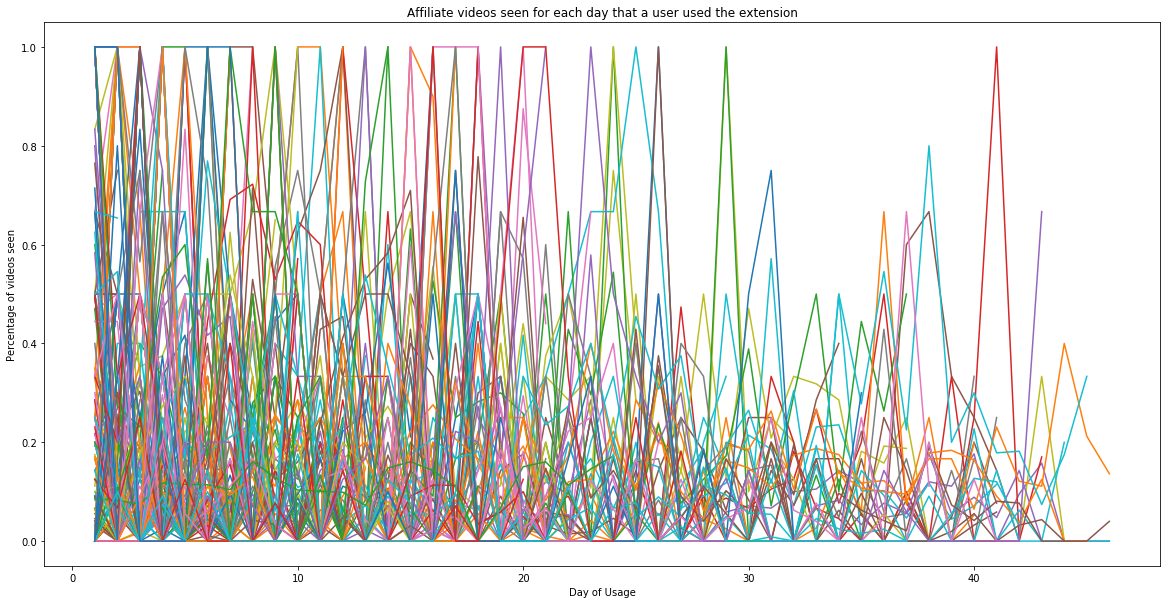

In [36]:
plt.figure(figsize=(20,10))
for user in day_indexed_integer_user_videos:
#print day_indexed_integer_user_videos
#     break
    days = day_indexed_integer_user_videos[user].keys()
    pcts = day_indexed_integer_user_videos[user].values()
    plt.plot(days, pcts)
plt.title("Affiliate videos seen for each day that a user used the extension")
plt.ylabel('Percentage of videos seen')
plt.xlabel('Day of Usage')
plt.show()

# Breakdown of Types of Affiliate Marketing per Video

In [37]:
seen_vids = {}
for item in items:
    vid_id = item[5]
    highlighted = item[4]
    action = item[1]
    if action not in ['aff', 'utm', 'coupon_code']:
        continue
    if action == 'utm':
        if highlighted not in utm_init_urls:
            continue
    if action == 'coupon_code':
        if highlighted not in tagged_coupon_codes:
            continue
        if tagged_coupon_codes[highlighted] != "1":
            continue
    #check if video has been seen
    if vid_id not in seen_vids:
        seen_vids[vid_id] = {}
    #check if we already have this highlighted portion
    if highlighted not in seen_vids[vid_id]:
        seen_vids[vid_id][highlighted] = action       

In [38]:
total_aff_vids = len(seen_vids.keys())
print total_aff_vids

4859


In [39]:
#individuals
has_aff = 0
has_utm = 0
has_coup = 0

#duplicates
aff_utm = 0
aff_coup = 0
utm_coup = 0
all_three = 0

total_highlights = {}
aff_highlights = {}
utm_highlights = {}
coup_highlights = {}
for vid in seen_vids.keys():
    aff_present = 0
    utm_present = 0
    coup_present = 0
    #count up the values
    for highlight in seen_vids[vid].keys():
        if seen_vids[vid][highlight] == "aff":
            aff_present += 1
        elif seen_vids[vid][highlight] == "utm":
            utm_present += 1
        elif seen_vids[vid][highlight] == "coupon_code":
            coup_present += 1
    #check the combinations
    if aff_present != 0:
        has_aff += 1
        if utm_present != 0:
            aff_utm += 1
            if coup_present != 0:
                all_three += 1
        if coup_present != 0:
            aff_coup += 1
    if utm_present != 0:
        has_utm += 1
        if coup_present != 0:
            utm_coup += 1
    if coup_present != 0:
        has_coup += 1
    
    # add to the lists
    highlights_in_this_video = coup_present + utm_present + aff_present
    if highlights_in_this_video not in total_highlights:
        total_highlights[highlights_in_this_video] = 0
    total_highlights[highlights_in_this_video] += 1
    if aff_present != 0:
        if aff_present not in aff_highlights:
            aff_highlights[aff_present] = 0
        aff_highlights[aff_present] += 1
    if utm_present != 0:
        if utm_present not in utm_highlights:
            utm_highlights[utm_present] = 0
        utm_highlights[utm_present] += 1
    if coup_present != 0:
        if coup_present not in coup_highlights:
            coup_highlights[coup_present] = 0
        coup_highlights[coup_present] += 1
        

In [40]:
print str(has_aff) + " videos with known aff links (" + get_pct(has_aff, total_aff_vids) + " of total)"
print str(has_utm) + " videos with utm params (" + get_pct(has_utm, total_aff_vids) + " of total)"
print str(has_coup) + " videos with coupon codes (" + get_pct(has_coup, total_aff_vids) + " of total)"

3222 videos with known aff links (66.31% of total)
1253 videos with utm params (25.79% of total)
1304 videos with coupon codes (26.84% of total)


In [41]:
print str(aff_utm) + " videos with aff and utm (" + get_pct(aff_utm, total_aff_vids) + " of total)"
print str(aff_coup) + " videos with aff and coup (" + get_pct(aff_coup, total_aff_vids) + " of total)"
print str(utm_coup) + " videos with utm and coup (" + get_pct(utm_coup, total_aff_vids) + " of total)"
print str(all_three) + " videos with all three (" + get_pct(all_three, total_aff_vids) + " of total)"

404 videos with aff and utm (8.31% of total)
353 videos with aff and coup (7.26% of total)
267 videos with utm and coup (5.49% of total)
104 videos with all three (2.14% of total)


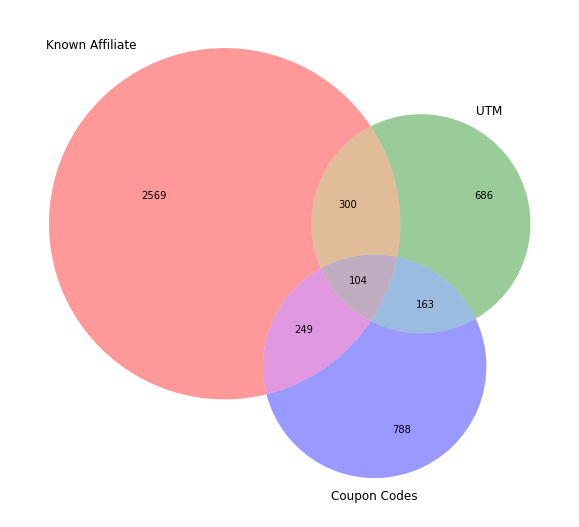

In [42]:
#get unique vals
only_aff_utm = aff_utm - all_three 
only_aff_coup = aff_coup - all_three
only_utm_coup = utm_coup - all_three

only_aff = has_aff - only_aff_utm - only_aff_coup - all_three
only_utm = has_utm - only_aff_utm - only_utm_coup - all_three
only_coup = has_coup - only_aff_coup - only_utm_coup - all_three

plt.figure(figsize=(10,10))
#plt.title("Breakdown of types of affiliate marketing in a video")
p = venn3(
    #(A, B, AB, C, AC, BC, ABC)
    subsets = (only_aff, only_utm, only_aff_utm, only_coup, only_aff_coup, only_utm_coup, all_three), 
    set_labels = ('Known Affiliate', 'UTM', 'Coupon Codes')
)
plt.show()

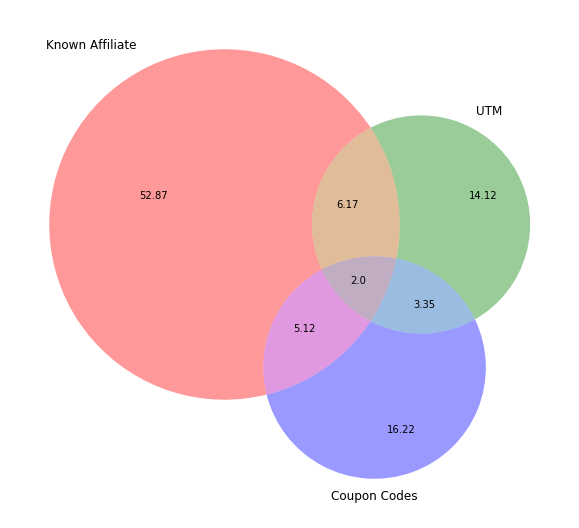

In [43]:
plt.figure(figsize=(10,10))
#plt.title("Breakdown of types of affiliate marketing in a video")
p = venn3(
    #(A, B, AB, C, AC, BC, ABC)
    subsets = (
        round((only_aff*1.0/total_aff_vids)*100, 2), 
        round((only_utm*1.0/total_aff_vids)*100, 2), 
        round((only_aff_utm*1.0/total_aff_vids)*100, 2), 
        round((only_coup*1.0/total_aff_vids)*100, 2), 
        round((only_aff_coup*1.0/total_aff_vids)*100, 2), 
        round((only_utm_coup*1.0/total_aff_vids)*100, 2), 
        round((all_three*1.0/total_aff_vids)*100), 2), 
    set_labels = ('Known Affiliate', 'UTM', 'Coupon Codes')
)
plt.show()

# Number of Highlights per Video

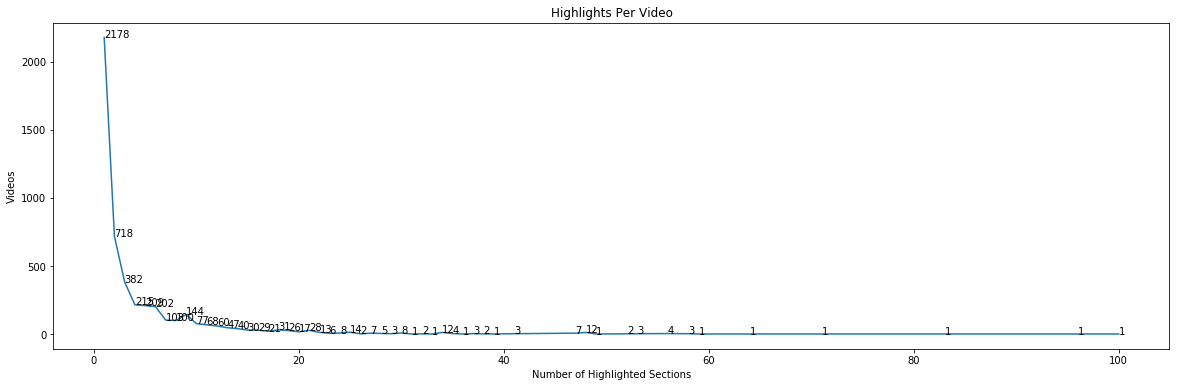

In [44]:
plt.figure(figsize=(20,6))
lists = sorted(total_highlights.items()) # sorted by key, return a list of tuples
x, y = zip(*lists)
plt.plot(x, y)
plt.title("Highlights Per Video")
plt.ylabel('Videos')
plt.xlabel('Number of Highlighted Sections')
for i in range(len(x)):
    if y[i] > 0:
        plt.annotate(str(y[i]), (x[i], y[i]))
plt.show()

In [45]:
multiple_highlights = 0
one_highlight = 0
for num_highlights in total_highlights.keys():
    if num_highlights > 1:
        multiple_highlights += total_highlights[num_highlights]
    else:
        one_highlight += total_highlights[num_highlights]

print one_highlight
print multiple_highlights
print get_pct(one_highlight, multiple_highlights+one_highlight)

2178
2681
44.82%


In [46]:
lines = {"Affiliates": aff_highlights, "UTMs": utm_highlights, "Coupons": coup_highlights}

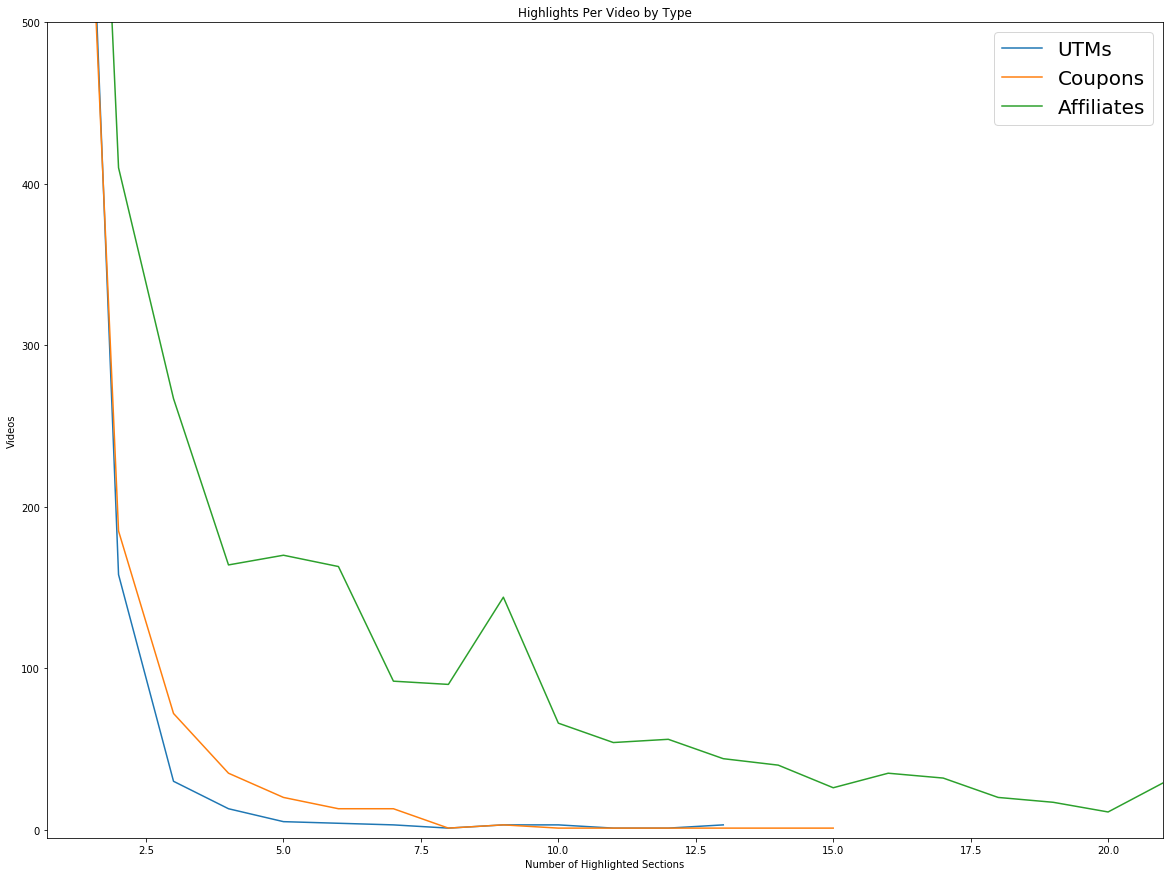

In [47]:
plt.figure(figsize=(20,15))
for kind in lines.keys():
    lists = sorted(lines[kind].items()) # sorted by key, return a list of tuples
    x, y = zip(*lists)
    plt.plot(x, y, label=kind)
plt.xlim(0.7,21)
plt.ylim(-5,500)
plt.title("Highlights Per Video by Type")
plt.legend(fontsize=20)
plt.ylabel('Videos')
plt.xlabel('Number of Highlighted Sections')
plt.show()

# Views Per Video

In [48]:
views_by_video = {}
for user in videos_by_user.keys():
    for t in videos_by_user[user].keys():
        for video in videos_by_user[user][t]:
            if video not in views_by_video:
                views_by_video[video] = 0
            views_by_video[video] += 1

In [49]:
views_breakdown = {}
for vid in views_by_video:
    views = views_by_video[vid]
    if views not in views_breakdown:
        views_breakdown[views] = 0
    views_breakdown[views] += 1

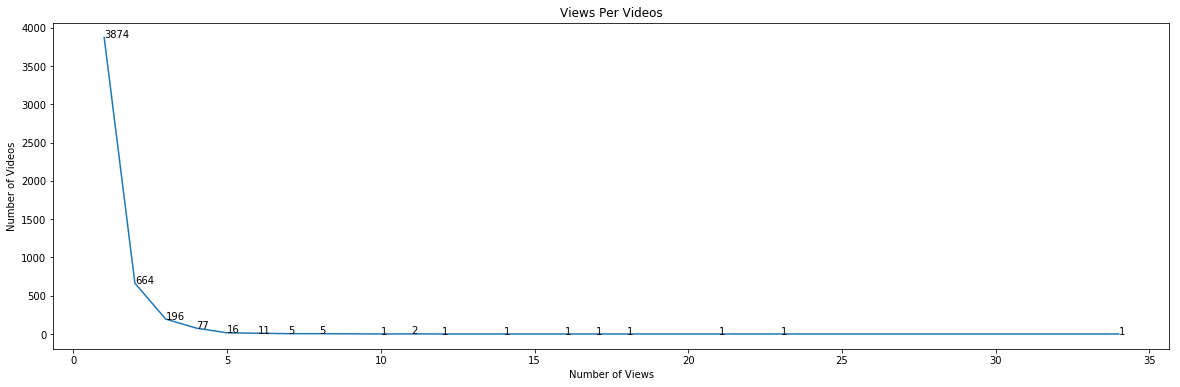

In [50]:
plt.figure(figsize=(20,6))
lists = sorted(views_breakdown.items()) # sorted by key, return a list of tuples
x, y = zip(*lists)
plt.plot(x, y)
plt.title("Views Per Videos")
plt.ylabel('Number of Videos')
plt.xlabel('Number of Views')
for i in range(len(x)):
    if y[i] > 0:
        plt.annotate(str(y[i]), (x[i], y[i]))
plt.show()

# Export

In [51]:
coupon_code_list = []
videos_list = []
vidids = {}
for vid in seen_vids.keys():
    for highlight in seen_vids[vid].keys():
        if seen_vids[vid][highlight] == "coupon_code":
            coupon_code_list.append(highlight)
        videos_list.append([vid, highlight, seen_vids[vid][highlight]])
        vidids[vid] = True

In [52]:
with open("coupons.tsv", 'w+') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    for cc in coupon_code_list:
        writer.writerow([cc])

In [53]:
with open("checkutms/utms.tsv", 'w+') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    for item in items:
        if item[1] == "utm":
            writer.writerow([item[4]])

In [54]:
with open("videos_init.tsv", 'w+') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    writer.writerow(["vidid"])
    for item in vidids.keys():
        writer.writerow([item])

Once the video ids are exported, we can use the YouTube API to get information about the videos. Then, we can continue here to inspect information about the videos that contain affiliate marketing.

# What Type of Videos contain Affiliate Marketing

In [55]:
headers = []
count = 0
video_data = {}
vidIdIndex = 0
with open("videos_joined.tsv", 'rt') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    for row in reader:
        count += 1
        if count == 1:
            headers = row
            for i in range(len(headers)):
                if headers[i] == "vidId":
                    vidIdIndex = i
                    break
            continue
        video_data[row[vidIdIndex]] = row

In [56]:
print headers

['vidViews', 'chanVideos', 'chanViews', 'vidTitle', 'vidCategory', 'chanStarted', 'chanId', 'vidId', 'chanTitle', 'vidPublishedAt', 'chanFollowers', 'vidLength', 'chanCountry']


## When were they published

In [57]:
years = {}
publishedAtIndex = -1 # start here because increment by 1 at the beginning
for header in headers:
    publishedAtIndex += 1
    if header == 'vidPublishedAt':
        break

In [58]:
for vid in video_data.keys():
    try:
        year = pd.to_datetime(video_data[vid][publishedAtIndex]).year
    except:
        pass
    if year not in years:
        years[year] = 0
    years[year] += 1

In [59]:
print years

{2016: 309, 2017: 627, 2018: 1078, 2019: 3031, 2006: 1, 2007: 5, 2008: 5, 2009: 52, 2010: 25, 2011: 63, 2012: 44, 2013: 68, 2014: 118, 2015: 157}


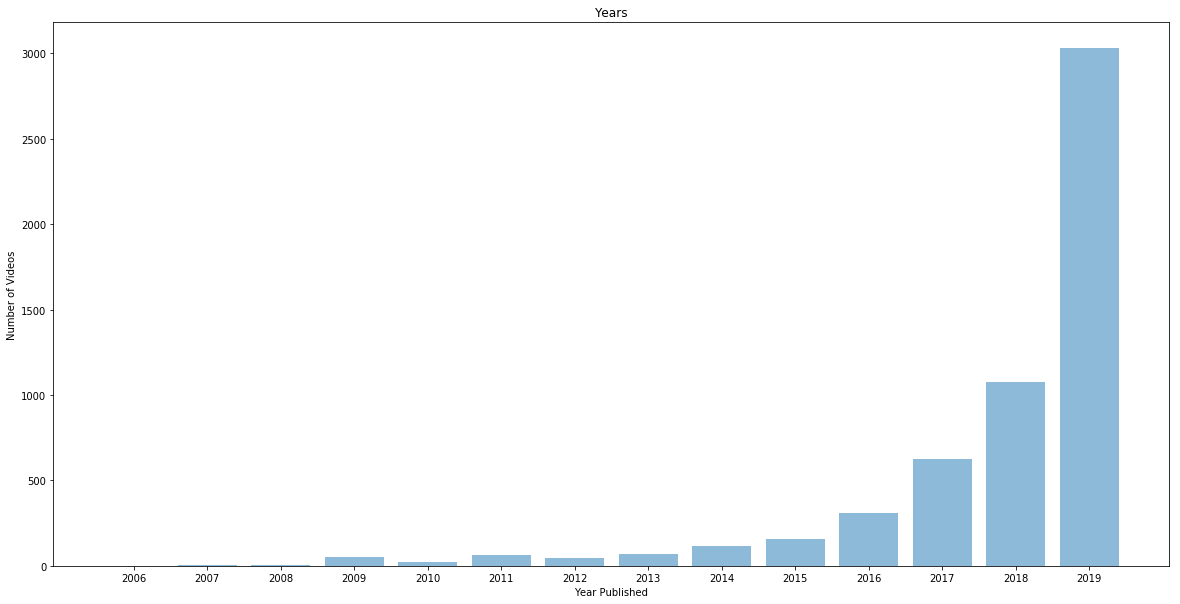

In [60]:
plt.figure(figsize=(20,10))
lists = sorted(years.items()) # sorted by key, return a list of tuples
x, y = zip(*lists)
plt.bar(x, y, align='center', alpha=0.5)
plt.xticks(x, sorted(years.keys()))
plt.title("Years")
plt.ylabel('Number of Videos')
plt.xlabel('Year Published')
plt.show()

In [61]:
is_2019 = 0
not_2019 = 0
for year in years.keys():
    if year == 2019:
        is_2019 += years[year]
    else:
        not_2019 += years[year]
print is_2019
print not_2019
print is_2019*1.0/(not_2019+is_2019)

3031
2552
0.542898083468


## Video Duration

In [62]:
durations = []
vidLengthIndex = -1 # start here because increment by 1 at the beginning
for header in headers:
    vidLengthIndex += 1
    if header == 'vidLength':
        break

In [63]:
for vid in video_data.keys():
    try:
        duration = isodate.parse_duration(video_data[vid][vidLengthIndex]).total_seconds()
        durations.append(duration)
    except:
        pass

In [64]:
df = pd.DataFrame(durations)

In [65]:
df.describe() #these are in seconds

,0
count,5583.000000
mean,909.442414
std,1718.652152
min,13.000000
25%,348.500000
50%,636.000000
75%,952.500000
max,41188.000000


## Video Views

In [66]:
viewCount = []
countIndex = -1 # start here because increment by 1 at the beginning
for header in headers:
    countIndex += 1
    if header == 'vidViews':
        break

In [67]:
for vid in video_data.keys():
    try:
        views = int(video_data[vid][countIndex])
        viewCount.append(views)
    except:
        pass

In [68]:
for item in viewCount:
    if type(item) is not int:
        print item
        print type(item)

In [69]:
df = pd.DataFrame(viewCount)
pd.set_option('display.float_format', lambda x: '%.1f' % x)

In [70]:
df.describe()

,0
count,5583.0
mean,10851406.2
std,96358236.3
min,0.0
25%,39612.0
50%,215478.0
75%,1156199.5
max,3389946643.0


## Video Category

In [71]:
categories = {}
vidCategoryIndex = -1 # start here because increment by 1 at the beginning
for header in headers:
    vidCategoryIndex += 1
    if header == 'vidCategory':
        break

In [72]:
cats = {42: 'Shorts', 43: 'Shows', 24: 'Entertainment', 25: 'News & Politics', 26: 'Howto & Style', 27: 'Education', 20: 'Gaming', 21: 'Videoblogging', 22: 'People & Blogs', 23: 'Comedy', 44: 'Trailers', 28: 'Science & Technology', 29: 'Nonprofits & Activism', 40: 'Sci-Fi/Fantasy', 41: 'Thriller', 1: 'Film & Animation', 2: 'Autos & Vehicles', 10: 'Music', 39: 'Horror', 38: 'Foreign', 15: 'Pets & Animals', 17: 'Sports', 19: 'Travel & Events', 18: 'Short Movies', 31: 'Anime/Animation', 30: 'Movies', 37: 'Family', 36: 'Drama', 35: 'Documentary', 34: 'Comedy', 33: 'Classics', 32: 'Action/Adventure'}

In [73]:
for vid in video_data.keys():
    category = video_data[vid][vidCategoryIndex]
    try:
        category = int(category)
    except:
        continue
    if category not in categories:
        categories[category] = 0
    categories[category] += 1

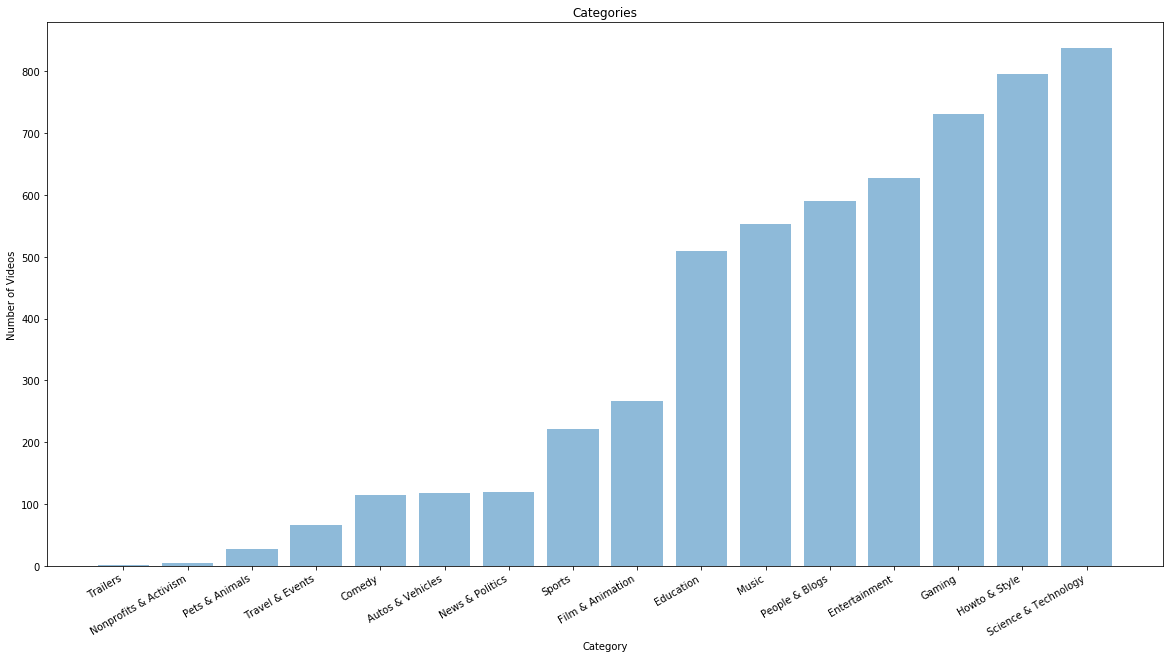

In [74]:
plt.figure(figsize=(20,10))
lists = sorted(categories.items(), key=operator.itemgetter(1)) #sort on value
x, y = zip(*lists)
cat_names = []
for cat in x:
    cat_names.append(cats[cat])
plt.bar(cat_names, y, align='center', alpha=0.5)
plt.xticks(rotation=30, horizontalalignment='right')
plt.title("Categories")
plt.ylabel('Number of Videos')
plt.xlabel('Category')
plt.show()

## Channel Country (if available)

In [75]:
countries = {}
chanCountryIndex = -1 # start here because increment by 1 at the beginning
for header in headers:
    chanCountryIndex += 1
    if header == 'chanCountry':
        break

In [76]:
for vid in video_data.keys():
    country = video_data[vid][chanCountryIndex]
    if country == "chanCountry":
        continue
    if country == "":
        country = "Unspecified"
    if country not in countries:
        countries[country] = 0
    countries[country] += 1

In [77]:
cleaned_countries = {}
LIMIT = 10
other = 0
for country in countries.keys():
    count = countries[country]
    if count < LIMIT:
        other += count
    else:
        cleaned_countries[country] = count
cleaned_countries["Other"] = other

In [78]:
print cleaned_countries

{'US': 2826, 'FR': 39, 'NL': 23, 'CA': 393, 'DE': 94, 'JP': 14, 'ZA': 10, 'Unspecified': 1132, 'NZ': 14, 'Other': 160, 'AU': 132, 'GB': 523, 'IN': 175, 'KW': 14, 'RO': 11, 'IE': 12, 'SE': 11}


In [79]:
us = 0
non_us = 0
for country in cleaned_countries:
    if country == 'US':
        us += cleaned_countries[country]
    else:
        non_us += cleaned_countries[country]
print us
print non_us

2826
2757


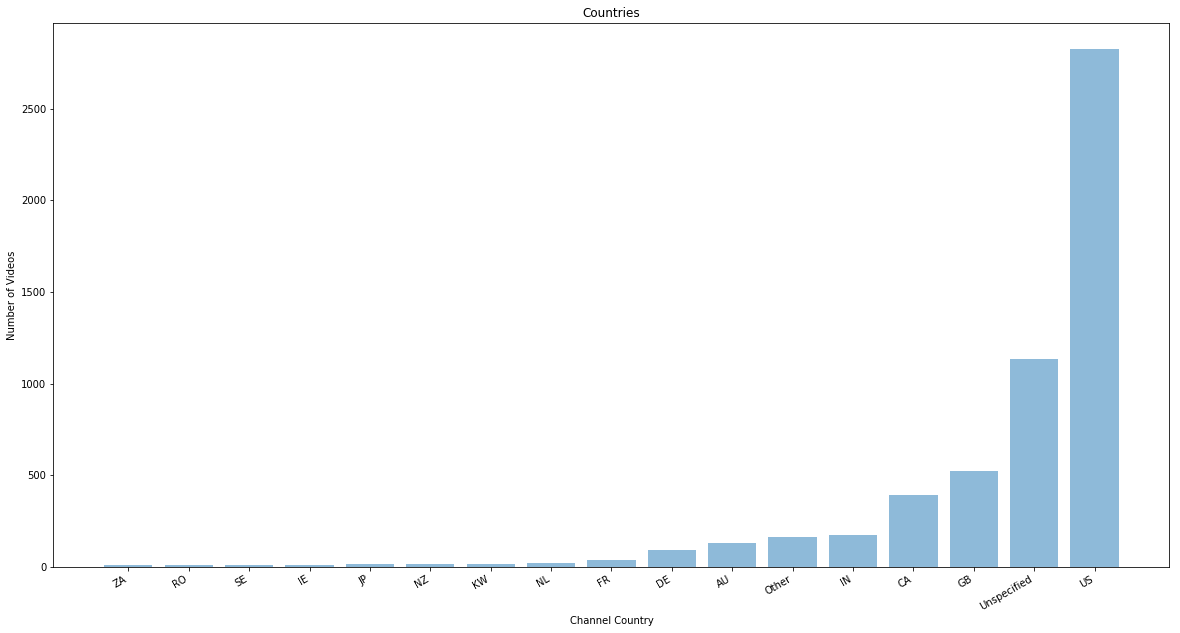

In [80]:
plt.figure(figsize=(20,10))
lists = sorted(cleaned_countries.items(), key=operator.itemgetter(1)) #sort on value
x, y = zip(*lists)
plt.bar(x, y, align='center', alpha=0.5)
plt.xticks(rotation=30, horizontalalignment='right')
plt.title("Countries")
plt.ylabel('Number of Videos')
plt.xlabel('Channel Country')
plt.show()

## Do any channels show up in multiple times?

Note: This section is somewhat weird in that there are two ways that you can slice the data. One is to check how many times a specific YouTuber was watched, regardless of the video. The other is to check if a YouTuber had multiple unique videos that were viewed. The latter shows 'repeat offenders' of sorts, and is interesting to inspect for the purpose of understanding affiliate marketing.

In [81]:
channels = {}
chanIdIndex = -1 # start here because increment by 1 at the beginning
for header in headers:
    chanIdIndex += 1
    if header == 'chanId':
        break

In [82]:
for vid in video_data.keys():
    channel = video_data[vid][chanIdIndex]
    if channel == "chanId":
        continue
    if channel not in channels:
        channels[channel] = 0
    channels[channel] += 1

In [83]:
frequencies = {}
for chan in channels.keys():
    freq = channels[chan]
    if freq not in frequencies:
        frequencies[freq] = 0
    frequencies[freq] += 1

In [84]:
print frequencies

{1: 1909, 2: 369, 3: 171, 4: 83, 5: 67, 6: 34, 7: 22, 8: 12, 9: 7, 10: 9, 11: 4, 12: 4, 13: 1, 14: 5, 15: 5, 16: 5, 17: 4, 18: 2, 19: 3, 20: 1, 21: 2, 22: 2, 23: 1, 26: 1, 27: 1, 28: 1, 30: 2, 33: 1, 37: 1, 40: 1, 43: 1, 66: 1, 78: 1, 91: 1}


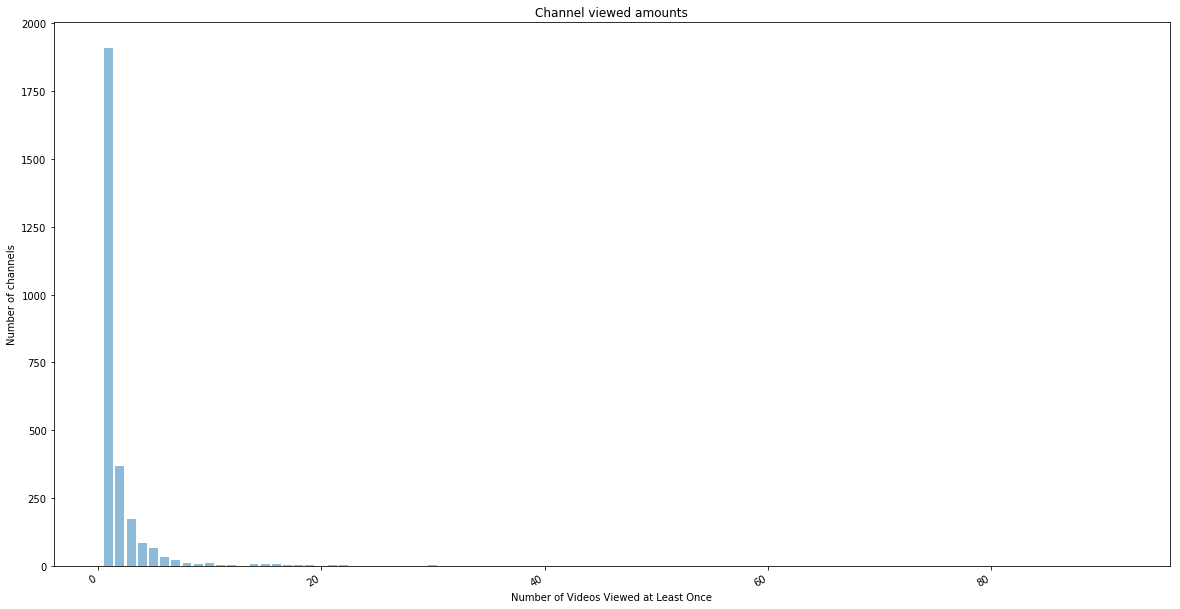

In [85]:
plt.figure(figsize=(20,10))
lists = sorted(frequencies.items(), key=operator.itemgetter(1)) #sort on value
x, y = zip(*lists)
plt.bar(x, y, align='center', alpha=0.5)
plt.xticks(rotation=30, horizontalalignment='right')
plt.title("Channel viewed amounts")
plt.ylabel('Number of channels')
plt.xlabel('Number of Videos Viewed at Least Once')
plt.show()

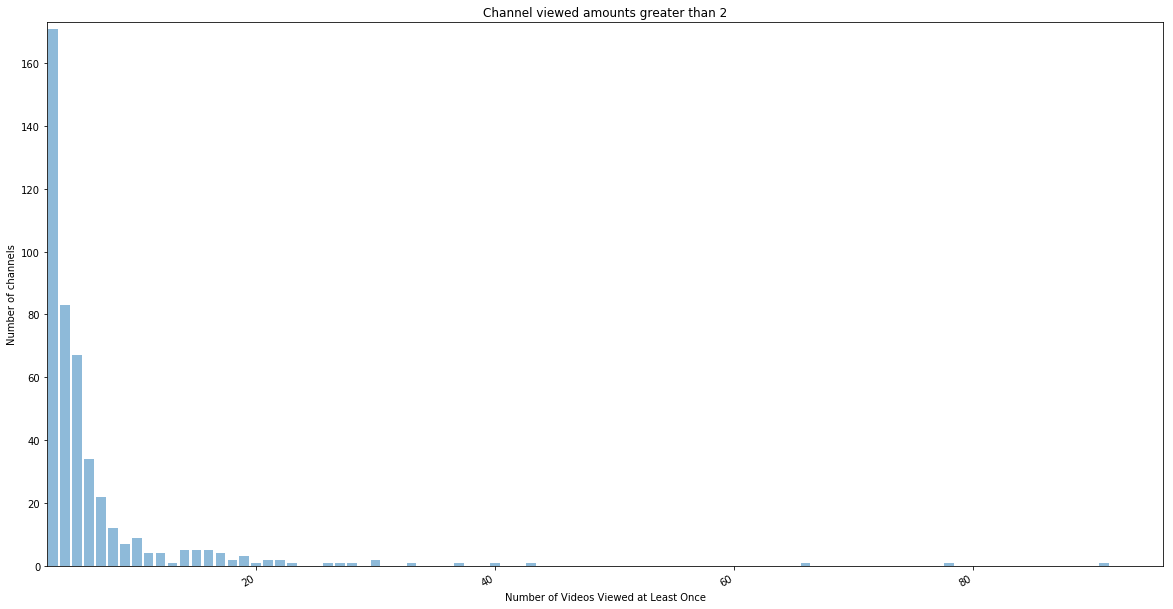

In [86]:
plt.figure(figsize=(20,10))
lists = sorted(frequencies.items(), key=operator.itemgetter(1)) #sort on value
x, y = zip(*lists)
plt.bar(x, y, align='center', alpha=0.5)
plt.xlim(2.5)
plt.ylim(0,frequencies[3]+2)
plt.xticks(rotation=30, horizontalalignment='right')
plt.title("Channel viewed amounts greater than 2")
plt.ylabel('Number of channels')
plt.xlabel('Number of Videos Viewed at Least Once')
plt.show()

In [87]:
most_viewed_chans = {}
MIN_VID_LIMIT = 10
maxi = 0
max_name = ""
for chan in channels.keys():
    vids = channels[chan] 
    if vids > MIN_VID_LIMIT:
        most_viewed_chans[chan] = {'videos': vids}
    if vids > maxi:
        maxi = vids
        max_name = chan

In [88]:
print str(max_name) + "\t" + str(maxi)

UCl4RpXZdQUhikTxBghAy1jQ	91


In [89]:
chanTitleIndex = -1 # start here because increment by 1 at the beginning
for header in headers:
    chanTitleIndex += 1
    if header == 'chanTitle':
        break
for videoId in video_data:
    vid = video_data[videoId]
    chanId = vid[chanIdIndex]
    if chanId in most_viewed_chans:
        if 'name' not in most_viewed_chans[chanId]:
            most_viewed_chans[chanId]['name'] = vid[chanTitleIndex]

In [90]:
tot = 0
for chan in most_viewed_chans:
    print most_viewed_chans[chan]
    tot += most_viewed_chans[chan]['videos']

{'name': 'Secular Talk', 'videos': 19}
{'name': 'Cereal Entrepreneur - Jordan Steen', 'videos': 18}
{'name': 'Movieclips', 'videos': 66}
{'name': 'Linus Tech Tips', 'videos': 78}
{'name': 'TED', 'videos': 12}
{'name': 'Omardizer | \xd8\xb9\xd9\x85\xd8\xb1\xd8\xaf\xd9\x8a\xd8\xb2\xd8\xb1', 'videos': 14}
{'name': 'Sweet Anita', 'videos': 91}
{'name': 'iFL TV', 'videos': 43}
{'name': 'Good Mythical Morning', 'videos': 15}
{'name': 'PostmodernJukebox', 'videos': 15}
{'name': 'The Infographics Show', 'videos': 30}
{'name': 'EA SPORTS FIFA', 'videos': 21}
{'name': 'Unbox Therapy', 'videos': 28}
{'name': 'BuzzFeedVideo', 'videos': 26}
{'name': 'PewDiePie', 'videos': 33}
{'name': 'Brett Kollmann', 'videos': 12}
{'name': 'Dave Lee', 'videos': 11}
{'name': 'Simply Nailogical', 'videos': 16}
{'name': 'WWE', 'videos': 17}
{'name': 'Marques Brownlee', 'videos': 14}
{'name': 'CollegeHumor', 'videos': 14}
{'name': 'ATHLEAN-X\xe2\x84\xa2', 'videos': 22}
{'name': 'TimTheTatman', 'videos': 18}
{'name': 

In [91]:
tot*1.0/total_aff_vids

0.23646840913768266

In [92]:
#percentage of all channels reflected in the above number
len(most_viewed_chans)*1.0/len(channels.keys())

0.018653986832479885

# Check Coupon Code Success

In [93]:
items = utm_items_saver

In [94]:
def get_domain(url):
    parsed_url = urltools.parse(url)
    return parsed_url.domain + "." + parsed_url.tld

In [95]:
domains = {}
for url in items:
    domain = get_domain(url)
    if domain not in domains:
        domains[domain] = 0 
    domains[domain] += 1

In [96]:
print len(domains.keys())
print len(items)

909
7386


In [97]:
count = 0
sorted_domains = sorted(domains.items(), key=operator.itemgetter(1), reverse=True)
for domain in sorted_domains:
    count += 1
    print domain
    if count > 100:
        break

('bit.ly', 905)
('goo.gl', 310)
('bladehq.com', 308)
('youtube.com', 213)
('vevo.com', 210)
('epidemicsound.com', 190)
('vevo.ly', 171)
('bellelily.com', 164)
('shopstyle.it', 145)
('shopstyle.com', 134)
('mbsy.co', 130)
('skillshare.com', 127)
('skl.sh', 113)
('ea.com', 93)
('gcn.eu', 83)
('easports.com', 81)
('spotify.com', 78)
('brilliant.org', 76)
('ojrq.net', 66)
('envato.market', 64)
('purplle.com', 57)
('shein.com', 53)
('elgato.com', 51)
('fiverr.com', 48)
('smarturl.it', 45)
('lga.to', 43)
('joinhoney.com', 42)
('mlpl.link', 40)
('nordvpn.com', 39)
('fairyseason.com', 38)
('nykaa.com', 35)
('nordvpn.net', 35)
('anrdoezrs.net', 34)
('dotomi.com', 34)
('wix.com', 34)
('emjcd.com', 34)
('dollarshaveclub.com', 32)
('tinyurl.com', 31)
('newegg.com', 31)
('bluehost.com', 30)
('gtn.io', 29)
('.', 28)
('musicbed.com', 27)
('banggood.com', 27)
('musicnotes.com', 27)
('mscbd.fm', 27)
('theschooloflife.com', 26)
('suebzimmerman.com', 25)
('geni.us', 24)
('pxf.io', 24)
('google.com', 24)
